In [1]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from plotly.offline import iplot, init_notebook_mode
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from datetime import datetime
import plotly.express as px

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

In [3]:
path = "../../../dataco-smart-supply-chain-for-big-data-analysis"
df=pd.read_csv(path+"/DataCoSupplyChainDataset.csv", encoding='latin1')

# Drop unnecessary columns
df = df.drop(['Customer Email', 'Product Status', 'Customer Password', 'Customer Street', 'Customer Fname',
              'Customer Lname', 'Product Description', 'Product Image', 'Order Zipcode', 'Customer Zipcode'], axis=1)

# Rename columns
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)

# Filter data for specific product card id (assuming 365 for now)
df = df[df['product_card_id'] == 365]

# Extract date strings and clean them
df['order_date'] = df['order_date_dateorders'].str.split(' ').str[0].str.strip()
df['order_date'] = pd.to_datetime(df['order_date'], format='%m/%d/%Y')

# Sort by order date
df = df.sort_values(by='order_date')

# Reset index
df.reset_index(drop=True, inplace=True)

# Extract necessary features and preprocess
df["time_idx"] = df["order_date"].dt.year * 12 + df["order_date"].dt.month
df["time_idx"] -= df["time_idx"].min()

In [4]:
df

,type,days_for_shipping_real,days_for_shipment_scheduled,benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,customer_city,...,order_state,order_status,product_card_id,product_category_id,product_name,product_price,shipping_date_dateorders,shipping_mode,order_date,time_idx
0,DEBIT,6,4,5.690000,50.389999,Late delivery,1,17,Cleats,Caguas,...,Querétaro,COMPLETE,365,17,Perfect Fitness Perfect Rip Deck,59.990002,1/7/2015 15:24,Standard Class,2015-01-01,0
1,PAYMENT,5,4,14.280000,50.990002,Late delivery,1,17,Cleats,Caguas,...,Panamá,PENDING_PAYMENT,365,17,Perfect Fitness Perfect Rip Deck,59.990002,1/6/2015 20:19,Standard Class,2015-01-01,0
2,DEBIT,2,4,43.119999,118.779999,Advance shipping,0,17,Cleats,Jersey City,...,Atlántida,ON_HOLD,365,17,Perfect Fitness Perfect Rip Deck,59.990002,1/3/2015 22:46,Standard Class,2015-01-01,0
3,CASH,3,4,-102.029999,152.970001,Advance shipping,0,17,Cleats,Del Rio,...,Santo Domingo,CLOSED,365,17,Perfect Fitness Perfect Rip Deck,59.990002,1/4/2015 19:37,Standard Class,2015-01-01,0
4,CASH,3,2,13.940000,49.790001,Late delivery,1,17,Cleats,Cordova,...,Distrito Federal,CLOSED,365,17,Perfect Fitness Perfect Rip Deck,59.990002,1/4/2015 12:36,Second Class,2015-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24510,DEBIT,4,4,45.389999,174.570007,Shipping on time,0,17,Cleats,Winter Park,...,Viena,COMPLETE,365,17,Perfect Fitness Perfect Rip Deck,59.990002,10/6/2017 10:40,Standard Class,2017-10-02,33
24511,DEBIT,3,4,-0.820000,58.790001,Advance shipping,0,17,Cleats,Caguas,...,Basilea-Ciudad,ON_HOLD,365,17,Perfect Fitness Perfect Rip Deck,59.990002,10/5/2017 12:04,Standard Class,2017-10-02,33
24512,TRANSFER,3,2,26.490000,57.590000,Late delivery,1,17,Cleats,Aurora,...,Isla de Francia,PROCESSING,365,17,Perfect Fitness Perfect Rip Deck,59.990002,10/5/2017 5:04,Second Class,2017-10-02,33
24513,PAYMENT,2,2,-302.350006,215.960007,Shipping on time,0,17,Cleats,Brooklyn,...,Isla de Francia,PENDING_PAYMENT,365,17,Perfect Fitness Perfect Rip Deck,59.990002,10/4/2017 4:43,Second Class,2017-10-02,33


In [5]:
df.groupby('product_card_id').size().max()

24515

In [6]:
# Assuming order item quantity is the target variable
max_prediction_length = 6
max_encoder_length = 24515
training_cutoff = df["time_idx"].max() - max_prediction_length

# Define the TimeSeriesDataSet with allow_missing_timesteps=True
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="order_item_quantity",
    group_ids=["product_card_id"],
    min_encoder_length=2,  # Adjust as needed
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    target_normalizer=None,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# Create validation set
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# Create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [7]:
# Configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # Log the learning rate
logger = TensorBoardLogger("lightning_logs")  # Log results to a TensorBoard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # Comment in for training, running validation every 30 batches
    fast_dev_run=True,  # Comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Define the Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=8,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # Uncomment for learning rate finder and otherwise, e.g., to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Number of parameters in network: 59.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Epoch 0: 100%|██████████| 1/1 [1:55:47<00:00,  0.00it/s, train_loss_step=3.110, val_loss=3.150, train_loss_epoch=3.110]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [1:55:47<00:00,  0.00it/s, train_loss_step=3.110, val_loss=3.150, train_loss_epoch=3.110]


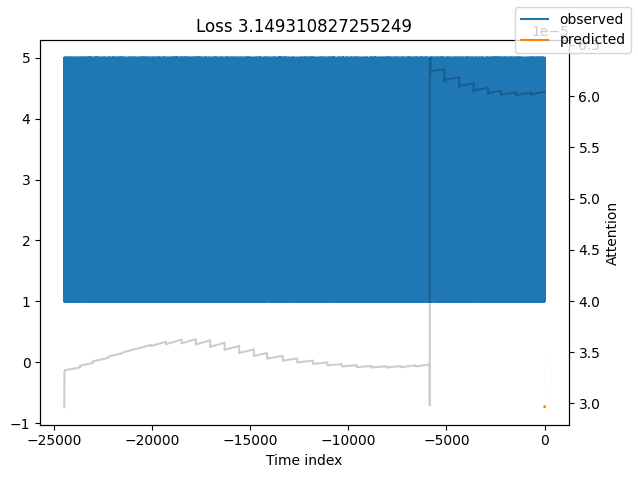

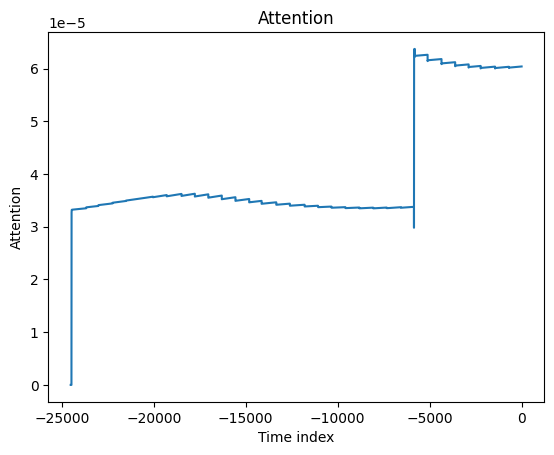

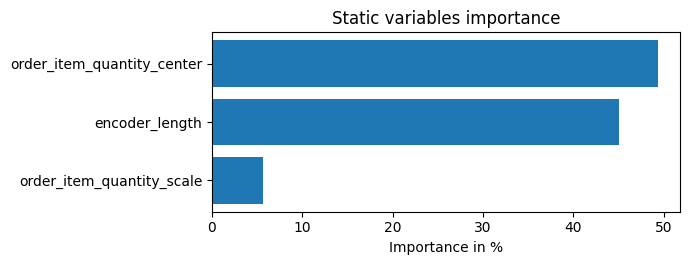

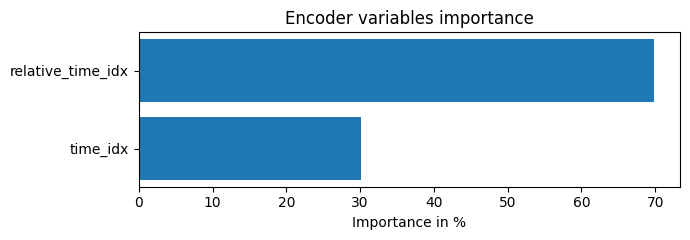

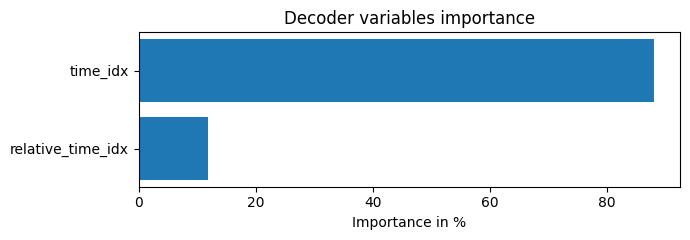

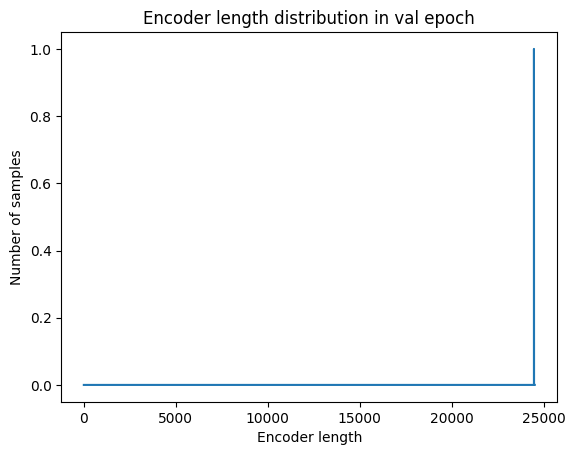

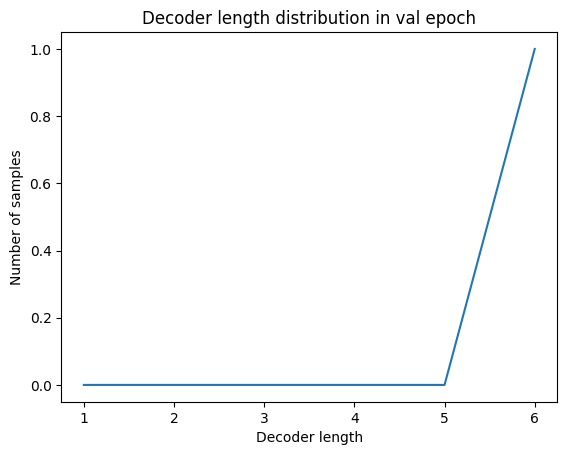

In [8]:
# Fit the network
trainer.fit(tft, train_dataloader, val_dataloader)

In [9]:
import torch
import pytorch_lightning as pl
from pytorch_forecasting.metrics import MAE, RMSE

# Define the metrics you want to use for evaluation
metrics = [MAE(), RMSE()]

# Put the model in evaluation mode
tft.eval()

# Initialize lists to store predictions and targets
predictions = []
targets = []

# Iterate over the validation dataloader to get predictions and targets
for batch in val_dataloader:
    x, y = batch
    with torch.no_grad():
        prediction = tft(x)["prediction"][:, :max_prediction_length]  # Slice the prediction tensor to match target length
    predictions.append(prediction.squeeze())  # Squeeze extra dimensions
    targets.append(y[0][:, :max_prediction_length])  # Slice the target tensor to match prediction length

# Concatenate the predictions and targets along the batch dimension
predictions = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

# Ensure both tensors have the same length along the sequence dimension
min_length = min(predictions.size(1), targets.size(1))
predictions = predictions[:, :min_length]
targets = targets[:, :min_length]

# Calculate the metrics
metric_values = {}
for metric in metrics:
    metric_value = metric(predictions, targets)
    metric_name = metric.__class__.__name__
    metric_values[metric_name] = metric_value.item()
    print(f"{metric_name}: {metric_value:.4f}")

# Optionally, you can calculate additional metrics or perform other evaluation tasks here


MAE: 20.2531
RMSE: 9.2321


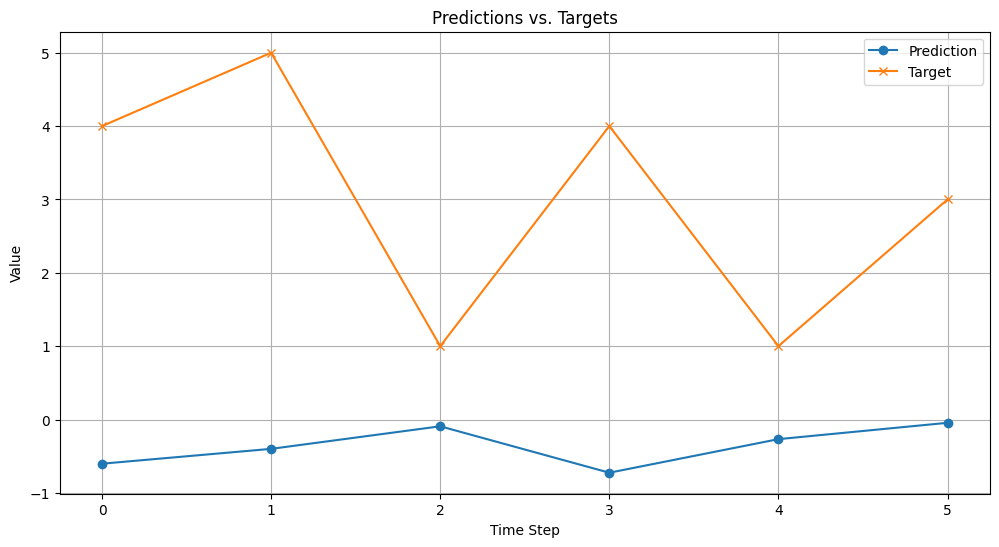

In [10]:
import matplotlib.pyplot as plt

# Choose a random sample index for visualization
sample_index = 0

# Plot the predictions and targets for the selected sample
plt.figure(figsize=(12, 6))
plt.plot(predictions[sample_index].numpy(), label='Prediction', marker='o')
plt.plot(targets[sample_index].numpy(), label='Target', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predictions vs. Targets')
plt.legend()
plt.grid(True)
plt.show()
